# Stack of NEON and other input data for AGB modelling  
Fine scale NEON data and other environmental covariates (everything except MERRA2) are warped to a common grid and extent  
Tiled data are mosaicked into VRTs
List of data are fed into a warp, and each warped file is written as a clipped geotiff by site, year  
Coarse data (MERRA2) are returned as a time-series table representing variables across time for a single lat/lon


In [2]:
import os
import sys
sys.path.append('/home/pmontesa/code/pygeotools')
from pygeotools.lib import iolib, malib, geolib, filtlib, warplib

import glob
from glob import glob
import rasterio
from rasterio.mask import mask
from rasterio.plot import show

from osgeo import gdal 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import geopandas as gpd
import pandas as pd
import numpy as np

import contextily as ctx
from shapely.geometry import box

In [3]:
def get_ndv(r_fn):
    with rasterio.open(r_fn) as src:
        return src.profile['nodata']

### Notes
__Drought data: Palmer drought severity index (PDSI)__  
/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/data/NEON_gridmetDROUGHT_parameters  

__SSURGO__  
soilDB from Beaudette et al:  
https://github.com/ncss-tech/soilDB/  
tutorial:  
https://ncss-tech.github.io/AQP/soilDB/WCS-demonstration-01.html  

other links:  
https://planetarycomputer.microsoft.com/dataset/gnatsgo-rasters  
https://casoilresource.lawr.ucdavis.edu/soil-properties/download.php

__Project's custom vegetation indices__  
Custom veg indices list:
https://docs.google.com/spreadsheets/d/1BQ3hY6CS93BHPzdscjHDEbswhTjP0M5mxM8JrhGkbYs/edit#gid=0

These are computed after clipping to site and thus dont exist yet.

In [94]:
NEON_HYPERSPECTRAL_PRODUCT_DICTIONARY = {
    'SOURCE' : 'Airborne_Hyperspectral',
    'TYPE' : 'Spectrometer',
    'VegIndices': 'DP3.30026.001',
    'WaterIndices': 'DP3.30019.001',
    'FPAR': 'DP3.30014.001',
    'LAI': 'DP3.30012.001',
    'Albedo': 'DP3.30011.001',
    'Reflectance': 'DP3.30006.001',     
}
NEON_LIDAR_PRODUCT_DICTIONARY = {
    'SOURCE' : 'Airborne_Lidar',
    'TYPE' : 'DiscreteLidar',
    'ClassifiedPointCloud': 'DP1.30003.001',
    'AspectGtif': 'DP3.30025.001',
    'CHMGtif': 'DP3.30024.001',
    'DSMGtif': 'DP3.30024.001', 
    'DTMGtif': 'DP3.30024.001', 
    'FSDGtif': 'DP3.30024.001', #CHM & RUG from Glenn
}

# Footprints of NEON tiles across all sites (run for LiDAR, should hold for hyperspectral - untested)
neon_footprints_fn = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints/footprints_DSM.gpkg'
neon_footprints_gdf = gpd.read_file(neon_footprints_fn)

# Get 'year' field from 'file' field
neon_footprints_gdf['year'] = neon_footprints_gdf['file'].str.split('_', expand=True)[0]
# Get NEON tile identifier needed to find corresponding hyperspectral h5 files (non spatial)
neon_footprints_gdf['tile_id'] = neon_footprints_gdf['file'].str.split('_', expand=True)[5] + '_' + neon_footprints_gdf['file'].str.split('_', expand=True)[6]

# Read NEON centroids
NEON_SITES_fn = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/data/neon_sites_centroids.csv'
neon_sites_df = pd.read_csv(NEON_SITES_fn)

neon_footprints_gdf.head()

,footprint_name,path,file,area_km2,area_ha,geometry,year,tile_id
0,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2017_NEON_D16_ABBY_DP3_547000_5062000_DSM.tif,1.0,100.0,"POLYGON ((-122.38332 45.70989, -122.38322 45.7...",2017,547000_5062000
1,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2017_NEON_D16_ABBY_DP3_556000_5063000_DSM.tif,1.0,100.0,"POLYGON ((-122.26758 45.71821, -122.26746 45.7...",2017,556000_5063000
2,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2017_NEON_D16_ABBY_DP3_548000_5065000_DSM.tif,1.0,100.0,"POLYGON ((-122.37017 45.73682, -122.37007 45.7...",2017,548000_5065000
3,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2017_NEON_D16_ABBY_DP3_550000_5072000_DSM.tif,1.0,100.0,"POLYGON ((-122.34372 45.79968, -122.34362 45.8...",2017,550000_5072000
4,None,/explore/nobackup/projects/ilab/data/AGB/Airbo...,2017_NEON_D16_ABBY_DP3_558000_5073000_DSM.tif,1.0,100.0,"POLYGON ((-122.24067 45.80804, -122.24054 45.8...",2017,558000_5073000


## SITE selection

In [95]:
SITE_SIZE_m = 1000 # length & width in meters of a site
SITE = 'MLBS'
YEAR = '2015'
REGION = '*' #'D07' # this not acutally needed
MAINDIR = '/explore/nobackup/projects/ilab/data/AGB'

### From SITE, get SITE EXTENT for clipping during Warp

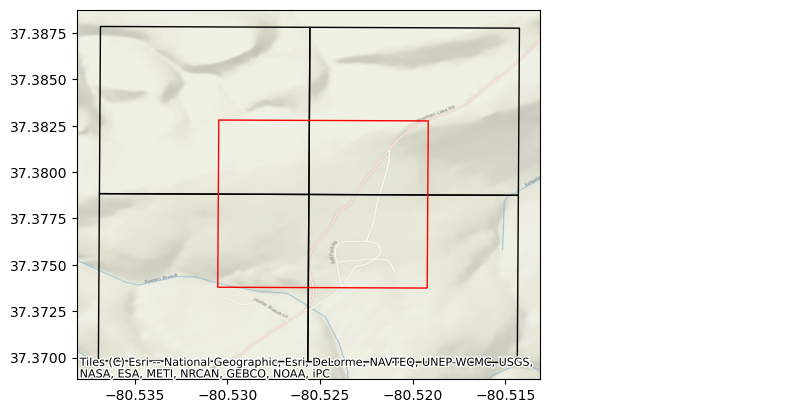

In [102]:
# Subset to site, get a geodataframe
site_df = neon_sites_df[neon_sites_df.site == SITE]
site_gdf = gpd.GeoDataFrame(site_df, geometry=gpd.points_from_xy(site_df.lon, site_df.lat))

# Get bbox of length & width SITE_SIZE around a centroid
site_gdf['left'], site_gdf['bottom'], site_gdf['right'], site_gdf['top'] = site_gdf['field_utm_x'] - (SITE_SIZE_m/2), site_gdf['field_utm_y'] - (SITE_SIZE_m/2), site_gdf['field_utm_x'] + (SITE_SIZE_m/2), site_gdf['field_utm_y'] + (SITE_SIZE_m/2) 
site_geometry = [box(x1, y1, x2, y2) for x1,y1,x2,y2 in zip(site_gdf.left, site_gdf.bottom, site_gdf.right, site_gdf.top)]

# Make site geodataframe in utm
site_gdf_utm = gpd.GeoDataFrame(site_gdf, geometry=site_geometry, crs=32600 + int(site_df['UTM zone']))
SITE_UTM_CRS = site_gdf_utm.crs

# Select NEON tiles that intersect the SITE's bbox
neon_footprints_gdf_subset = gpd.sjoin(neon_footprints_gdf[neon_footprints_gdf.year == YEAR].to_crs(SITE_UTM_CRS), site_gdf_utm, how='inner', predicate='intersects')

# Plot the NEON tiles that intersect the SITE
ax1 = neon_footprints_gdf_subset.to_crs(4326).plot(facecolor='None', ec='black')

# Plot site extent
ax1 = site_gdf_utm.to_crs(4326).plot(facecolor='None', ec='r', ax=ax1)

# Show map of site extent
ax1 = ctx.add_basemap(ax1, crs=4326, 
        #source = ctx.providers.Gaode.Satellite
        #source = ctx.providers.Esri.WorldShadedRelief
        #source = ctx.providers.Esri.WorldGrayCanvas
        source = ctx.providers.Esri.NatGeoWorldMap
        #source = ctx.providers.Esri.WorldImagery
        #source = ctx.providers.Esri.DeLorme
    )

#from shapely.geometry import shape
#shape(site_gdf_utm['geometry']).bounds

# Get extent as tuple used for warp
SITE_EXTENT = rasterio.features.bounds(site_gdf_utm['geometry'])

# Convert to list of strings for output dir name
SITE_EXTENT_LIST = [str(x) for x in SITE_EXTENT]

# Use this list of NEON tile ids to find all NEON hyperspectral h5 files that intersect
NEON_TILE_ID_LIST = neon_footprints_gdf_subset.tile_id.to_list()

## Find NEON hyperspectral reflectance h5 files

In [112]:
fn_hyper_h5_list = [glob(f'/explore/nobackup/projects/ilab/data/AGB/Airborne_Hyperspectral/DP3.30006.001/neon-aop-products/{YEAR}/FullSite/{REGION}/{YEAR}_{SITE}_*/L3/Spectrometer/Reflectance/*{TILE_ID}*.h5') for TILE_ID in NEON_TILE_ID_LIST]
fn_hyper_h5_list = flat_list = [item for sublist in fn_hyper_h5_list for item in sublist]
fn_hyper_h5_list
#/explore/nobackup/projects/ilab/data/AGB/Airborne_Hyperspectral/DP3.30006.001/neon-aop-products/2017/FullSite/D07/2017_MLBS_2/L3/Spectrometer/Reflectance

['/explore/nobackup/projects/ilab/data/AGB/Airborne_Hyperspectral/DP3.30006.001/neon-aop-products/2015/FullSite/D07/2015_MLBS_1/L3/Spectrometer/Reflectance/2015_NEON_D07_MLBS_DP3_541000_4136000_reflectance.h5',
 '/explore/nobackup/projects/ilab/data/AGB/Airborne_Hyperspectral/DP3.30006.001/neon-aop-products/2015/FullSite/D07/2015_MLBS_1/L3/Spectrometer/Reflectance/2015_NEON_D07_MLBS_DP3_542000_4136000_reflectance.h5',
 '/explore/nobackup/projects/ilab/data/AGB/Airborne_Hyperspectral/DP3.30006.001/neon-aop-products/2015/FullSite/D07/2015_MLBS_1/L3/Spectrometer/Reflectance/2015_NEON_D07_MLBS_DP3_541000_4137000_reflectance.h5',
 '/explore/nobackup/projects/ilab/data/AGB/Airborne_Hyperspectral/DP3.30006.001/neon-aop-products/2015/FullSite/D07/2015_MLBS_1/L3/Spectrometer/Reflectance/2015_NEON_D07_MLBS_DP3_542000_4137000_reflectance.h5']

## Process NEON vegetation indices

In [ ]:
# Handled with Roger's wrangler process
# TODO: make sure the output goes to the OUT_EXTENT_DIR with is a string with SITE, YEAR, BBOX

## Set output SITE EXTENT dir

In [13]:
# Output extent dir
DIR_SITE_EXTENT = '_'.join([SITE, YEAR] + SITE_EXTENT_LIST)
OUT_EXTENT_DIR = os.path.join(MAINDIR, 'test','beta_pmm', DIR_SITE_EXTENT)
!mkdir -p $OUT_EXTENT_DIR

## Coarse-scale data

In [6]:
dir_landsat = f'{MAINDIR}/LCMS'
dir_ssurgo  = f'{MAINDIR}/SSURGO/soilDB' #{SITE}/2020-07-01'
dir_merra2  = f'{MAINDIR}/MERRA2'
dir_pdsi = f'{MAINDIR}/drought'

##### coarse data lists of grids

In [7]:
fn_landsat_list  = [os.path.join(dir_landsat, 'LCMS_CONUS_v2021-7_Most_Recent_Year_of_Fast_Loss.tif'), os.path.join(dir_landsat, 'LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Fast_Loss.tif')]
fn_ssurgo_list = [ x for x in glob(os.path.join(dir_ssurgo, f'*{SITE}*.tif')) if "tilejson" not in x and 'rendered' not in x ]
fn_ssurgo_list

['/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_wfifteenbar_r_0_25.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_dbthirdbar_r_0_25.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_awc_r_0_25.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_ph1to1h2o_r_0_25.tif']

## Fine-scale data:  

##### Test -- of a single pre-existing tile extent

In [8]:
if False:
    TILE_COORD = '540000_4136000'
    TILE_NAME = f'{YEAR}_NEON_{REGION}_{SITE}_DP3_{TILE_COORD}' 

    # Output extent dir
    OUT_EXTENT_DIR = os.path.join(MAINDIR, 'test','beta_pmm',TILE_COORD)
    !mkdir -p $OUT_DIR

##### Test -- fine data list of grids

In [9]:
if False:
    fn_lidar_fsd_list = glob(f'/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/{YEAR}/FullSite/{REGION}/{YEAR}_{SITE}_2/L3/DiscreteLidar/FSDGtif/{TILE_NAME}*.tif')
    fn_lidar_dtm_list = glob(f'/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/{YEAR}/FullSite/{REGION}/{YEAR}_{SITE}_2/L3/DiscreteLidar/DTMGtif/{TILE_NAME}*.tif')

    fn_lidar_list    = fn_lidar_fsd_list + fn_lidar_dtm_list
    fn_hyper_list    = glob(f'/explore/nobackup/projects/ilab/projects/AGB/test{SITE}/airHyper/{TILE_NAME}*.tif')

    # Copy into OUT_DIR the layers that wont end up getting warped
    for f in fn_lidar_list + fn_hyper_list:
        to_fn = os.path.join(OUT_DIR , os.path.basename(f))
        print(to_fn)
        !cp $f $to_fn

    fn_finescale_list = fn_lidar_list + fn_hyper_list

##### fine data list of grids (using VRTs)
Build the VRTs of tiled data from NEON (lidar and hyperspectral)  
some data are tiles across the larger study extent and need to be in a virtual mosaic to facilitate clipping anywhere within this extent

In [10]:
NEON_PROD_TILED_LIST = ['FSDGtif', 'DTMGtif', 'DSMGtif'] # Add hyperspectral here

In [11]:
fn_neon_vrt_list = []

for NEON_PROD in NEON_PROD_TILED_LIST:

    TIF_SEARCH_LIST = ['']
    
    # Special case
    if NEON_PROD == 'FSDGtif':
        TIF_SEARCH_LIST = ['CHM','RUG']
        
    for TIF_SEARCH in TIF_SEARCH_LIST:

        # Get the level of the data from the product
        PROD_LEVEL = NEON_LIDAR_PRODUCT_DICTIONARY[NEON_PROD].split('.')[0].split('DP')[1]
        
        SEARCH_STRING = f'{MAINDIR}/{NEON_LIDAR_PRODUCT_DICTIONARY["SOURCE"]}/{NEON_LIDAR_PRODUCT_DICTIONARY[NEON_PROD]}/neon-aop-products/{YEAR}/FullSite/{REGION}/{YEAR}_{SITE}_*/L{PROD_LEVEL}/{NEON_LIDAR_PRODUCT_DICTIONARY["TYPE"]}/{NEON_PROD}/*{TIF_SEARCH}.tif'
        print(f'Data search string: {SEARCH_STRING}') 
        fn_neon_prod_list = glob(SEARCH_STRING)
        #print(fn_neon_prod_list[0:10])
        
        # gdalbuilvrt here

        OUT_DIR = os.path.join(MAINDIR, 'test','beta_pmm')
        vrt_fn = os.path.join(OUT_DIR,f'{SITE}_{YEAR}_{NEON_PROD}_{TIF_SEARCH}.vrt')

        vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest', addAlpha=False)
        my_vrt = gdal.BuildVRT(vrt_fn , fn_neon_prod_list, options=vrt_options)
        my_vrt = None
        
        # Update the list used for warping
        fn_neon_vrt_list.append(vrt_fn)
        
fn_neon_vrt_list

fn_finescale_list = fn_neon_vrt_list

Data search string: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2015/FullSite/*/2015_MLBS_*/L3/DiscreteLidar/FSDGtif/*CHM.tif
Data search string: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2015/FullSite/*/2015_MLBS_*/L3/DiscreteLidar/FSDGtif/*RUG.tif
Data search string: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2015/FullSite/*/2015_MLBS_*/L3/DiscreteLidar/DTMGtif/*.tif
Data search string: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2015/FullSite/*/2015_MLBS_*/L3/DiscreteLidar/DSMGtif/*.tif


Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2015/FullSite/D07/2015_MLBS_1/L3/DiscreteLidar/DSMGtif/2015_NEON_D07_MLBS_DP3_539000_4139000_DSM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2015/FullSite/D07/2015_MLBS_1/L3/DiscreteLidar/DSMGtif/2015_NEON_D07_MLBS_DP3_536000_4134000_DSM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2015/FullSite/D07/2015_MLBS_1/L3/DiscreteLidar/DSMGtif/2015_NEON_D07_MLBS_DP3_538000_4138000_DSM.tif: TIFFReadDir

### Combine the lists (substacks)

In [14]:
#fn_list = fn_lidar_list + fn_hyper_list + fn_landsat_list + fn_ssurgo_list
fn_list = fn_finescale_list + fn_landsat_list + fn_ssurgo_list
print(len(fn_list))
fn_list

10


['/explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2015_FSDGtif_CHM.vrt',
 '/explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2015_FSDGtif_RUG.vrt',
 '/explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2015_DTMGtif_.vrt',
 '/explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2015_DSMGtif_.vrt',
 '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Fast_Loss.tif',
 '/explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Fast_Loss.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_wfifteenbar_r_0_25.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_dbthirdbar_r_0_25.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_awc_r_0_25.tif',
 '/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_ph1to1h2o_r_0_25.tif']

In [15]:
# Check nodata values of input data
ndv_list = [get_ndv(fn) for fn in fn_list]
print(ndv_list)

[-9999.0, -9999.0, -9999.0, -9999.0, 0.0, 0.0, nan, nan, nan, nan]


## Warp the grids

In [16]:
# ---Doing the warp ---
# Warp with a write out 
warp_ds_list = warplib.diskwarp_multi_fn(fn_list, res=1, extent=SITE_EXTENT, t_srs=fn_finescale_list[0], r='mode', dst_ndv=-10001, outdir=OUT_EXTENT_DIR)


Warping all inputs to the following:
Resolution: 1.0
Extent: [541567.6, 4136443.0, 542567.6, 4137443.0]
Projection: '+proj=utm +zone=17 +datum=WGS84 +units=m +no_defs'
Resampling alg: mode

1 of 10: /explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2015_FSDGtif_CHM.vrt
nl: 1000 ns: 1000 res: 1.000
0...10...20...30...40...50...60...70...80...90...2 of 10: /explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2015_FSDGtif_RUG.vrt
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 10: /explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2015_DTMGtif_.vrt
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 10: /explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2015_DSMGtif_.vrt
nl: 1000 ns: 1000 res: 1.000


Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2015/FullSite/D07/2015_MLBS_1/L3/DiscreteLidar/DSMGtif/2015_NEON_D07_MLBS_DP3_541000_4136000_DSM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2015/FullSite/D07/2015_MLBS_1/L3/DiscreteLidar/DSMGtif/2015_NEON_D07_MLBS_DP3_542000_4136000_DSM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2015/FullSite/D07/2015_MLBS_1/L3/DiscreteLidar/DSMGtif/2015_NEON_D07_MLBS_DP3_541000_4137000_DSM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
Warning 1: /explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2015/FullSite/D07/2015_ML

100 - done.
0...10...20...30...40...50...60...70...80...90...5 of 10: /explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Most_Recent_Year_of_Fast_Loss.tif
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...40...50...60...70...80...90...6 of 10: /explore/nobackup/projects/ilab/data/AGB/LCMS/LCMS_CONUS_v2021-7_Year_of_Highest_Probability_of_Fast_Loss.tif
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...40...50...60...70...80...90...7 of 10: /explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_wfifteenbar_r_0_25.tif
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...40...50...60...70...80...90...8 of 10: /explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_dbthirdbar_r_0_25.tif
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...40...50...60...70...80...90...9 of 10: /explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_awc_r_0_25.tif
nl: 1000 ns: 1000 res: 1.000
100 - done.
0...10...20...30...4

### Note: NoDATA values only changed if the file end up being warped

In [17]:
print([iolib.get_ndv_ds(ds) for ds in warp_ds_list])

[-10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0]


### Plot arrays

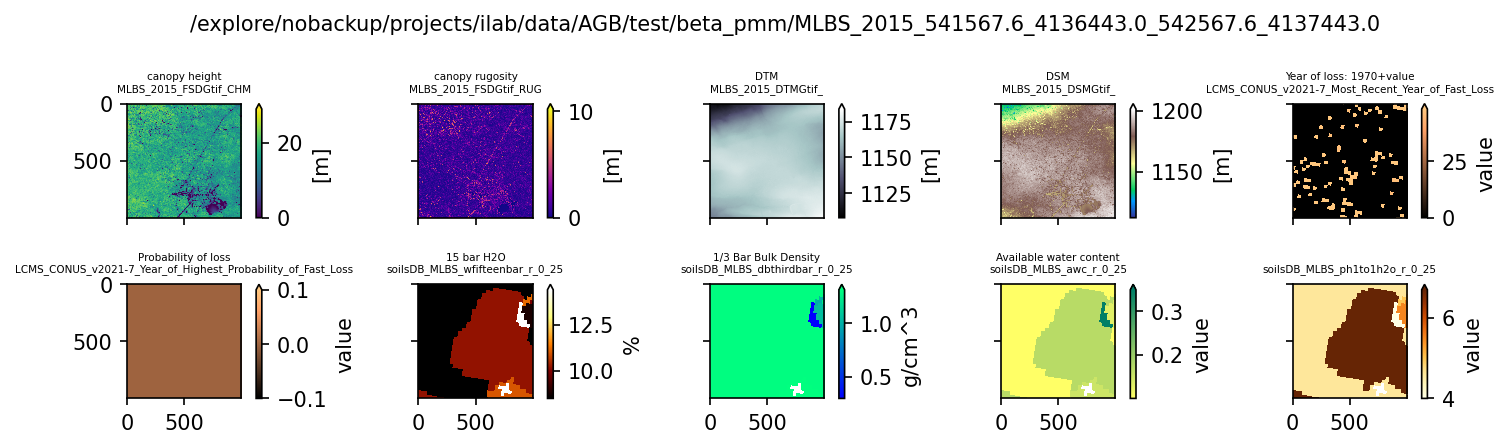

In [60]:
warp_ma_list = [iolib.ds_getma(ds) for ds in warp_ds_list]
dif_LCMS_ma = warp_ma_list[4] - warp_ma_list[5]
warp_ma_list[5] = dif_LCMS_ma

layer_names = ['canopy height', 'canopy rugosity', 'DTM', 'DSM', 'Year of loss: 1970+value', 'Probability of loss', '15 bar H2O','1/3 Bar Bulk Density', 'Available water content', '']
cmap_list = ['viridis', 'plasma', 'bone', 'terrain', 'copper', 'copper','afmhot','winter','summer_r', 'YlOrBr']
label_list = ['[m]', '[m]', '[m]', '[m]', 'value', 'value' , '%','g/cm^3', 'value', 'value']
f, axa = plt.subplots(2,5,sharex=True, sharey=True, dpi=150, figsize=(10,3)) 
for n, ax in enumerate(axa.ravel()):
    im = ax.imshow(warp_ma_list[n], interpolation='none', cmap=cmap_list[n])
    ax.set_title(layer_names[n] + '\n' + os.path.splitext(os.path.basename(fn_list[n]))[0], fontsize=5)
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cb = f.colorbar(im, cax=cax, orientation='vertical', extend='max')
    cb.set_label(label_list[n])
#f.suptitle(f'{SITE}: {YEAR}')
f.suptitle(f'{OUT_EXTENT_DIR}', fontsize=10)
plt.tight_layout()

## Coarse-scale data  
### Combine MERRA2 into a single time series file  
this table is a daily time-series of 10 vars from 2016-2021 for a single MERRA2 grid cell at `(-80.5248, 37.37831 )`   
'mean_temperature..K.''max_temperature..K.''min_temperature..K.''vpd..kPa.''high_temperature_day''freezing_day''growing_degree..K.''solar_radiation..W.m2.''soil_moisture..m3.m3.''precipitation..mm.day.'

In [17]:
STARTYEAR, ENDYEAR = [2014, 2021]
merra2_df = pd.concat(pd.read_csv(fn) for fn in sorted(glob(f'{dir_merra2}/*.csv')) )
merra2_df
merra2_df.to_csv(os.path.join(OUT_EXTENT_DIR, f'merra2_{SITE}_daily_{STARTYEAR}_{ENDYEAR}.csv'))

### Combine Drought (PDSI) data into a single time series file 

In [18]:
STARTYEAR, ENDYEAR = [2000, 2022]
pdsi_df = pd.concat(pd.read_csv(fn, skiprows=10) for fn in sorted(glob(f'{dir_pdsi}/{SITE}*.csv')) )
pdsi_df
pdsi_df.to_csv(os.path.join(OUT_EXTENT_DIR, f'pdsi_{SITE}_daily_{STARTYEAR}_{ENDYEAR}.csv'))

In [19]:
OUT_EXTENT_DIR

'/explore/nobackup/projects/ilab/data/AGB/test/beta_pmm/MLBS_2015_541567.6_4136443.0_542567.6_4137443.0'